In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



In [3]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [4]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

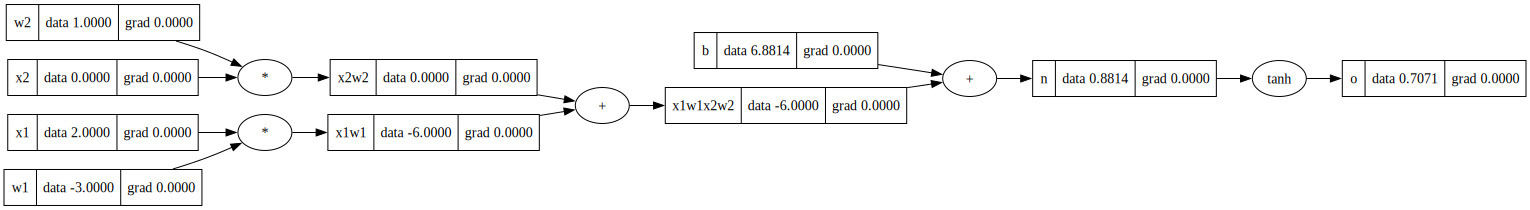

In [5]:
draw_dot(o)

In [6]:
o.backward()

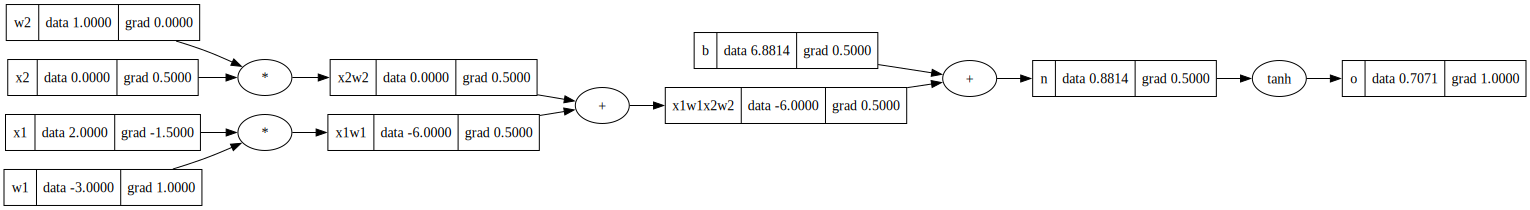

In [7]:
draw_dot(o)